## Final Project Submission

Please fill out:
* Student name: Zhiqiang Sun
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Business understanding
We have had the house selling records for the last few years. With these data, I want to build a model in which I can use the features in the data about the house to predict the price. In this case, we can guide both the seller and buyer to their business. The seller can use the model to predict the selling price of their house and if they need to do any renovation before selling their home. The buyer can have some suggestions about which kind of house they can afford based on their budget. 
To the details goal： 
1. polish the data which have no meaning or is null to the price.
2. remove the features which do not contribute to the house price. 
3. check if there are some high correlated features in which some of them can be removed.
4. build the linear regression model.
5. check how the features can contribute to the house change. 

In [2]:
# import all the necessary library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Loading the Data 
In the cell below, I load the house data into a dataframe and checked it's dimension and datatype.

In [36]:
# Your code here - remember to use markdown cells for comments as well!
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


I need to steply remove and polish most of the columns which is not contribute to the price of house
1. The id is not related to the price
2. Split the date file to month and year.
3. Since the lat and long data is high related to the zipcode, I need to remove them.
4. Remodle the zip column with only the first three number
5. Remove the sqft_living15 and sqft_lot15 from columns.
6. Change the yr_built to the age of house at sold time
7. Change the yr_renovated to if the house is renovated and is the renovated within 10 and 30 years at sold.
8. Remove the 'sqft_living15', 'sqft_lot15'

In [37]:
df = df.drop(['id', 'lat', 'long'], axis  = 1)
df.zipcode = [int(x/10) for x in df.zipcode ]
month = []
year = []
for date in df.date:
    month.append(int(date.split('/')[0]))
    year.append(int (date.split('/')[2]))
df['month'] = month
df['year'] = (year)

df.fillna(value = 0, inplace=True)

df['is_renovated'] = [1  if x > 0 else 0 for x in df['yr_renovated']  ]
df['renovated_age'] = df['year'] - df['yr_renovated']
df['renovated_age2'] = [0 if x >1000 else x for x in df['renovated_age']]
df['renovated_10'] = [1 if (x <10) & (x >0)  else 0 for x in df['renovated_age2']]
df['renovated_30'] = [1 if (x <30) & (x >0) else 0 for x in df['renovated_age2']]
df['age_sold'] = df['year'] - df['yr_built']

#df['price'] = df['price']/(df['price'].max())
df['sqft_basement'] = [float(x) if x != '?' else 0.0 for x in df['sqft_basement']]

to_drop = ['date', 'sqft_living15', 'sqft_lot15' ,  'yr_renovated','yr_built', 'renovated_age', 'renovated_age2'  ] #, 
df_precessed = df.drop(to_drop, axis  = 1)
df_precessed = df_precessed[(df_precessed.bedrooms<33) & (df_precessed.age_sold >0)]
df_precessed.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,month,year,is_renovated,renovated_10,renovated_30,age_sold
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,9817,10,2014,0,0,0,59
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,9812,12,2014,1,0,1,63
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,9802,2,2015,0,0,0,82
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,9813,12,2014,0,0,0,49
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,9807,2,2015,0,0,0,28


In [38]:
# I checked the number of unique value for each of the columns
df_precessed.nunique()

price            3446
bedrooms           11
bathrooms          29
sqft_living       993
sqft_lot         9643
floors              6
waterfront          2
view                5
condition           5
grade              11
sqft_above        904
sqft_basement     300
zipcode            19
month              12
year                2
is_renovated        2
renovated_10        2
renovated_30        2
age_sold          115
dtype: int64

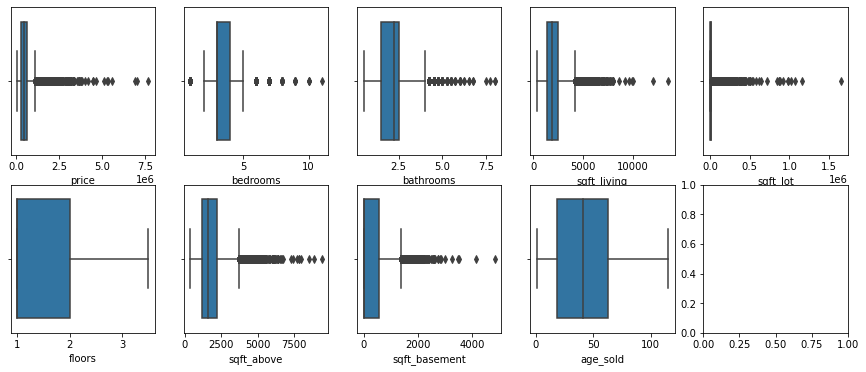

In [39]:
# I then drawed the distribution of each of the columns 
# which had more than 10 unique value to check if there is any outlier values.
fig, axs = plt.subplots(2,5, figsize = (15,6))
plt1 = sns.boxplot(df_precessed['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_precessed['bedrooms'], ax = axs[0,1])
plt3 = sns.boxplot(df_precessed['bathrooms'], ax = axs[0,2])
plt4 = sns.boxplot(df_precessed['sqft_living'], ax = axs[0,3])
plt5 = sns.boxplot(df_precessed['sqft_lot'], ax = axs[0,4])
plt1 = sns.boxplot(df_precessed['floors'], ax = axs[1,0])
plt2 = sns.boxplot(df_precessed['sqft_above'], ax = axs[1,1])
plt3 = sns.boxplot(df_precessed['sqft_basement'], ax = axs[1,2])
plt4 = sns.boxplot(df_precessed['age_sold'], ax = axs[1,3])




In [40]:
#The above figures show that there are multipal columns contain some outlier data. 
#I then collected all the columns and remove them 
to_modify = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','sqft_above','sqft_basement']
for col in to_modify:
    Q1 = df_precessed[col].quantile(0.25)
    Q3 = df_precessed[col].quantile(0.75)
    IQR = Q3 - Q1
    df_precessed = df_precessed[(df_precessed[col] >= Q1 - 1.5*IQR) & (df_precessed[col] <= Q3 + 1.5*IQR)]

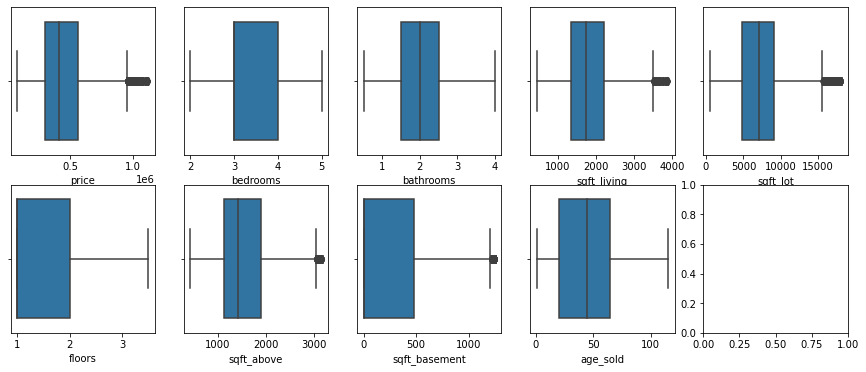

In [41]:
# check the data after modification
fig, axs = plt.subplots(2,5, figsize = (15,6))
plt1 = sns.boxplot(df_precessed['price'], ax = axs[0,0])
plt2 = sns.boxplot(df_precessed['bedrooms'], ax = axs[0,1])
plt3 = sns.boxplot(df_precessed['bathrooms'], ax = axs[0,2])
plt4 = sns.boxplot(df_precessed['sqft_living'], ax = axs[0,3])
plt5 = sns.boxplot(df_precessed['sqft_lot'], ax = axs[0,4])
plt1 = sns.boxplot(df_precessed['floors'], ax = axs[1,0])
plt2 = sns.boxplot(df_precessed['sqft_above'], ax = axs[1,1])
plt3 = sns.boxplot(df_precessed['sqft_basement'], ax = axs[1,2])
plt4 = sns.boxplot(df_precessed['age_sold'], ax = axs[1,3])


The data looks much better now with very few of outlier numbers.

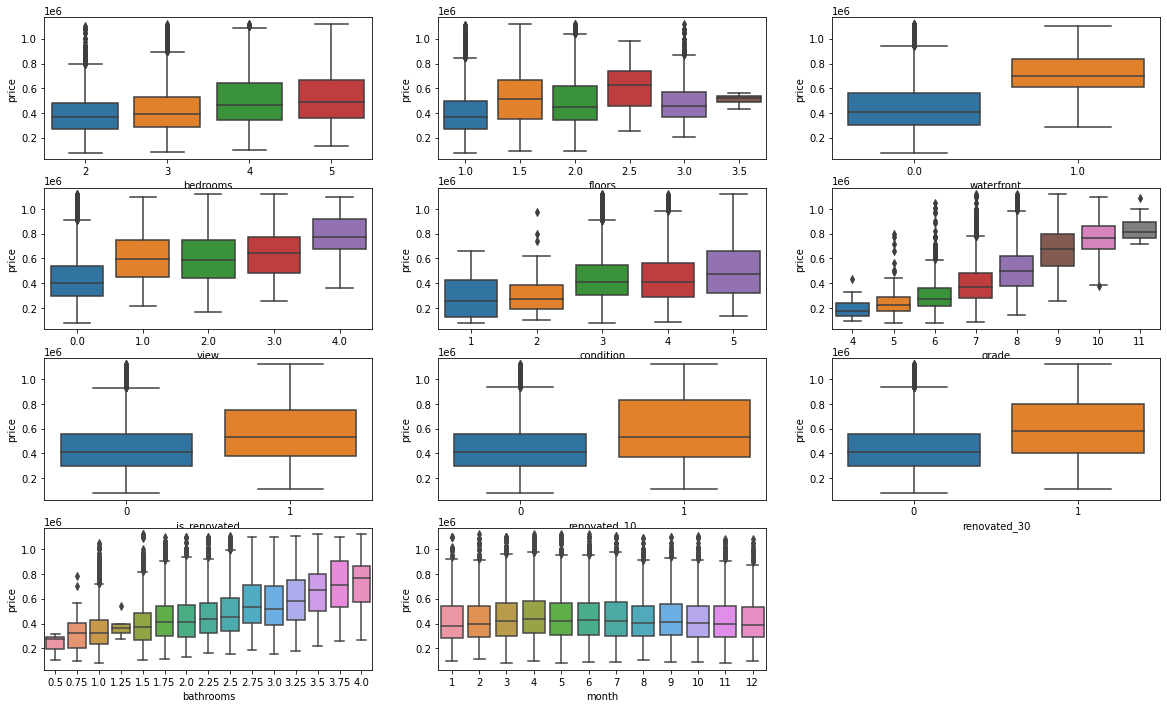

In [42]:
#  In order to check the relationship between the price with most of the columns with few unique numbers, 
# I plot their relations in seperate figures.
plt.figure(figsize=(20, 12))
plt.subplot(4,3,1)
sns.boxplot(x = 'bedrooms', y = 'price', data = df_precessed)
plt.subplot(4,3,2)
sns.boxplot(x = 'floors', y = 'price', data = df_precessed)
plt.subplot(4,3,3)
sns.boxplot(x = 'waterfront', y = 'price', data = df_precessed)
plt.subplot(4,3,4)
sns.boxplot(x = 'view', y = 'price', data = df_precessed)
plt.subplot(4,3,5)
sns.boxplot(x = 'condition', y = 'price', data = df_precessed)
plt.subplot(4,3,6)
sns.boxplot(x = 'grade', y = 'price', data = df_precessed)
plt.subplot(4,3,7)

sns.boxplot(x = 'is_renovated', y = 'price', data = df_precessed)
plt.subplot(4,3,8)
sns.boxplot(x = 'renovated_10', y = 'price', data = df_precessed)
plt.subplot(4,3,9)
sns.boxplot(x = 'renovated_30', y = 'price', data = df_precessed)
plt.subplot(4,3,10)
sns.boxplot(x = 'bathrooms', y = 'price', data = df_precessed)
plt.subplot(4,3,11)

sns.boxplot(x = 'month', y = 'price', data = df_precessed)
plt.show()

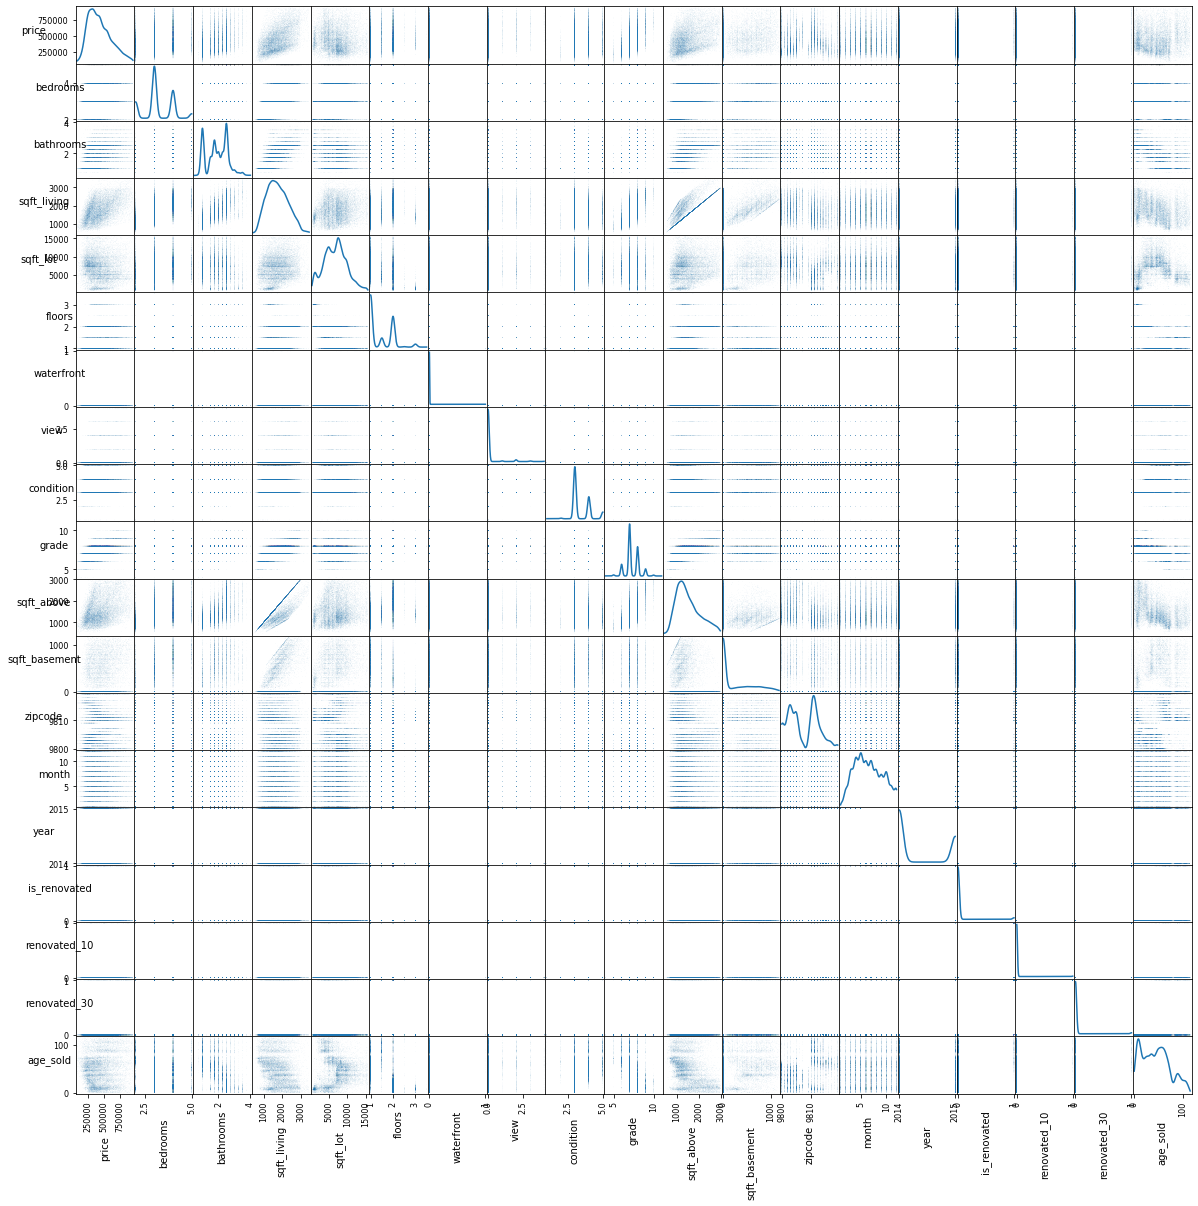

In [198]:
# The scatter plot of each two columns shows in general how the feature realated to each other and if there is any obvious
# correlation between them.
scatter_matrix = pd.plotting.scatter_matrix(
    df_precessed,
    figsize  = [20, 20],
    marker   = ".",
    s        = 0.2,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0)


Base on the scatter figure above,  there are several features correlated with each other. However, visual approach to finding correlation cannot be automated, so a numeric approach is a good next step.

In [43]:
# I tested the pairs of feature with correlation more than 0.75.
df = df_precessed.corr().abs().stack().reset_index().sort_values(0, ascending = False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns = ['level_0', "level_1"], inplace  = True)
df.columns = ['cc']
df.drop_duplicates(inplace = True)
df[(df.cc>.7) & (df.cc<1)]


,cc
pairs,
"(sqft_living, sqft_above)",0.814755
"(renovated_30, is_renovated)",0.808098
"(month, year)",0.786899


There are three pairs of features high related with each other. I need to remove at least one of the features in each pair. Comparing the last list, I decided to delete the columns sqft_above, renovated_30, year, month. 

In [44]:
to_drop = ['sqft_above', 'renovated_30', 'year', 'month' ]
df_precessed = df_precessed.drop(to_drop,axis  = 1 )

# Regression
Until now, I finished the polish of the all the features and then I will split the data to trainning and testing parts to do the fitting.  

In [45]:
#split the data to training and testing part
from sklearn.model_selection import train_test_split
y = df_precessed['price']
X = df_precessed.drop('price', axis  = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12297 4099 12297 4099


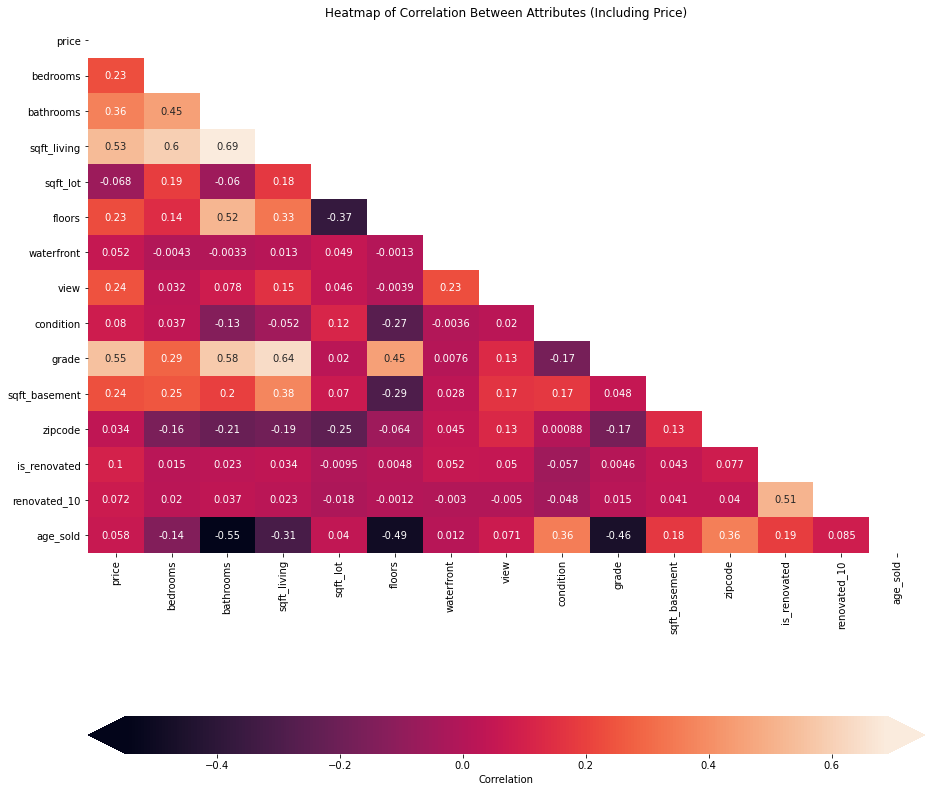

In [14]:
#check heatmap of the data to find out the most correlated feature and make the base line

heatmap_data = pd.concat([y_train, X_train], axis = 1)
corr = heatmap_data.corr()

#setup figure for heatmap
fig, ax = plt.subplots(figsize = (15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Price)");

Base on the heatmap above, the feature most strongly correlated with the price is sqft_living. So I selected the sqft_living to make the baseline of linear regression fitting. 

In [15]:
most_correlated_feature = "grade"

In [16]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

baseline_model = LinearRegression()


splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.30102469477546406
Validation score: 0.3146285604628449



Because we are using the .score method of LinearRegression, these are r-squared scores. That means that each of them represents the amount of variance of the target ( price) that is explained by the model's features (currently just the number of grade) and parameters (intercept value and coefficient values for the features).

In general this seems like not a very strong model. However, it is getting nearly identical performance on training subsets compared to the validation subsets, explaining around 50% of the variance both times.

We will need to add more features to the model to check if there is any improvement.

# Build a Model with All Numeric Features 

In [17]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.5322810924227112
Validation score: 0.5360008901543358

Baseline Model
Train score:      0.30102469477546406
Validation score: 0.3146285604628449


Our second model got better scores on the training data, and better scores on the validation data. However, I still want to continue to check how each feature work in general. Then I choose to check the coef value of the regression

#  Select the Best Combination of Features

In [46]:
import statsmodels.api as sm

sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1003.
Date:                Sat, 06 Nov 2021   Prob (F-statistic):               0.00
Time:                        05:04:40   Log-Likelihood:            -1.6225e+05
No. Observations:               12297   AIC:                         3.245e+05
Df Residuals:                   12282   BIC:                         3.246e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.322e+06   2.49e+06      0.933      0.351   -2.55e+06     7.2e+06
bedrooms      -1.786e+04   1960.903     -9.106      0.000   -2.17e+04    -1.4e+04
bathrooms      2.235e+04   3078.018      7.261      0.000    1.63e+04    2.84e+04
sqft_living     103.8368      3.834     27.086      0.000      96.322     111.351
sqft_lot         -7.3467      0.429    -17.118      0.000      -8.188      -6.505
floors         1.846e+04   3442.038      5.362      0.000    1.17e+04    2.52e+04
waterfront      1.43e+05   3.59e+04      3.983      0.000    7.26e+04    2.13e+05
view           3.082e+04   2246.465     13.717      0.000    2.64e+04    3.52e+04
condition      2.043e+04   1982.824     10.304      0.000    1.65e+04    2.43e+04
grade          1.045e+05   1933.535     54.029      0.000    1.01e+05    1.08e+05
sqft_basement    11.0299      4.511      2.445      0.014       2.188      19.872
zipcode        -305.0042    253.600     -1.203      0.229    -802.099     192.091
is_renovated  -6014.9547   8429.046     -0.714      0.475   -2.25e+04    1.05e+04
renovated_10   5.219e+04   1.56e+04      3.351      0.001    2.17e+04    8.27e+04
age_sold       2685.7902     60.005     44.759      0.000    2568.171    2803.410
==============================================================================
Omnibus:                      619.304   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              895.400
Skew:                           0.462   Prob(JB):                    3.68e-195
Kurtosis:                       3.945   Cond. No.                     2.64e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# Base on the p value, I temperaly select 10 columns in which p<0.05
select_cat = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
              'sqft_basement', 'renovated_10', 'age_sold']
X_train_third = X_train[select_cat]

third_model = LinearRegression()

third_model_scores = cross_validate(
    estimator=third_model,
    X=X_train_third,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())

print("second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())



current Model
Train score:      0.53218577738026
Validation score: 0.536160764472546
second Model
Train score:      0.5322810924227112
Validation score: 0.5360008901543358

Baseline Model
Train score:      0.30102469477546406
Validation score: 0.3146285604628449


There is a little bit improve on the prediction, but very little.
 I tried to selecting Features with sklearn.feature_selection

In [239]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
waterfront: True
view: True
condition: True
grade: True
sqft_basement: True
zipcode: False
is_renovated: False
renovated_10: True
age_sold: True


The RFE methods give me the same selection of features above.

The results showed that the auto sedlected features did not give better score than the third model.

Now, I remade the third model features to best_features to validate the final model.

In [21]:
# Base on the train score and validation score, the best columns until now is the third model. 


X_train_final = X_train[select_cat]
X_test_final = X_test[select_cat]


final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test_final, y_test)

0.5262655735621476

In [22]:
# import the mse to check the mse value
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, final_model.predict(X_test_final), squared=False)

130331.41577992862

445683.2471334472

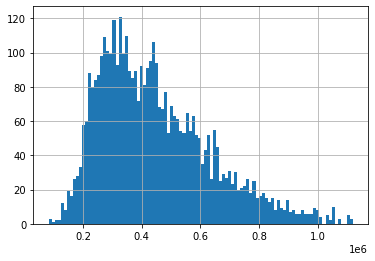

In [23]:
#check the distribution of price in test data
y_test.hist(bins = 100)
y_test.mean()

"""
This means that for an average house price, this algorithm will be off by about $130331 thousands. Given that the mean value of house price is 445683, the algorithm can patially set the price. However, we still want to have a human double-check and adjust these prices rather than just allowing the algorithm to set them.
"""

In [24]:
print(pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms         -17734.819592
bathrooms         22333.279123
sqft_living         104.197345
sqft_lot             -7.266691
floors            17895.940478
waterfront       140605.432066
view              30502.795377
condition         20867.253746
grade            104396.240619
sqft_basement        10.140670
renovated_10      46690.148414
age_sold           2655.946868
Name: Coefficients, dtype: float64

Intercept: -670009.6123770761


The coefficients of the selected features shows that the sqft_living is the most important features which affected the house price since the sqft_living is normally more than 1000. The affection of features sqft_lot and sqft_basement are very small even they are negtive numbers.  The affection of grade on the house is very big also. Also, if the house is renovated within 10 years, the price will increased 46690 dollars. If there is waterfront of the house, the price of the house will increase dramtically with 140605.

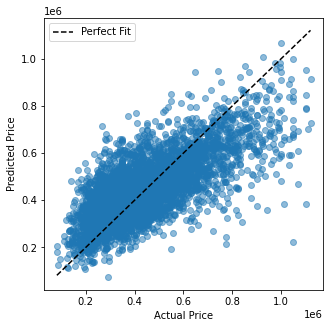

In [245]:
# For the validation, I first plot the scatter plot of Predicted Price vs the Actual Price
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots(figsize =(5,5))

perfect_line = np.arange(y_test.min(), y_test.max())
#perfect_x = [0, 1]
#perfect_y = [0, 1]

#ax.plot(perfect_x, perfect_y, linestyle="--", color="black", label="Perfect Fit")
ax.plot(perfect_line,perfect_line, linestyle="--", color="black", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

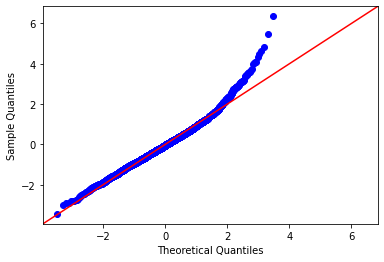

In [247]:
# test the data by normal distribution
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

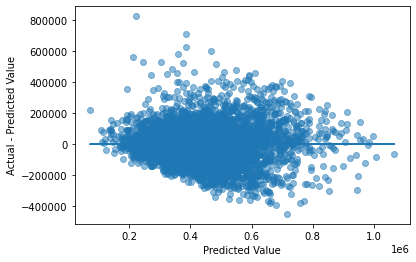

In [248]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

The validation of prediction and real data shows that the prediction price for most house whose price is low (20% of the max price) is close to the real price.  qqplot showes that the house price is well predicted when the house price is not very high. However, for the high value price house, the prediction is not very acturate. There is a lot of shift of prediction price when the house value increase especialy when house price is more than 2 million. 

# Summary
Our model predicted well the house price on many of the features. The Coefficients are like between
bedrooms         -17734,
bathrooms         22333,
sqft_living         104,
sqft_lot             -7,
floors            17895,
waterfront       140605 ,
view              30502,
condition         20867 ,
grade            104396,
sqft_basement        10 ,
renovated_10      46690,
age_sold           2655,

To the buyer, they can estimate the price of the house base on the features of the house. 
To the seller, if they want to sell the house in a better value, they can try to renovate the house and make water front if possible. 
